Loaded 1620 images total.


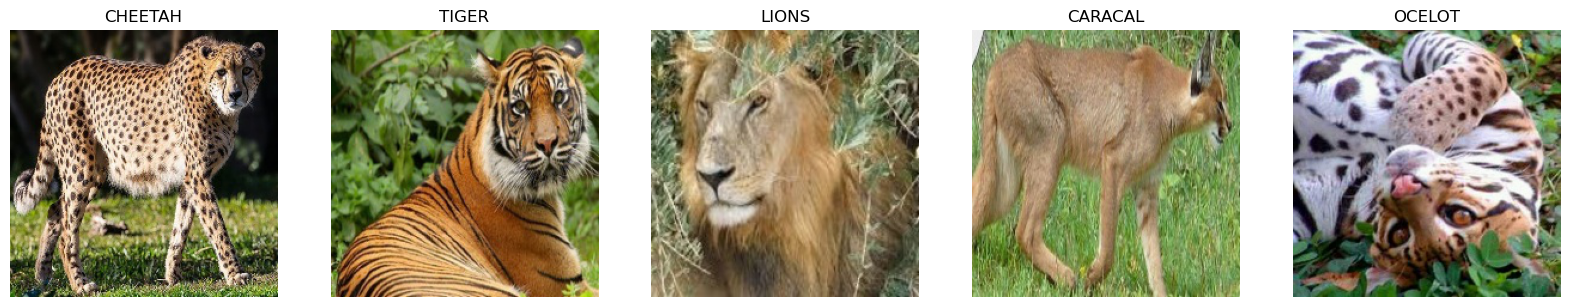

In [6]:
################## Libraries, Images  ##################
from src.utils import *
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import t
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import save_model, load_model
from tensorflow.keras import utils
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


################## LOAD IMAGES ##################

# Loading images
images, labels = load_imgs("data/Wild Cats Dataset",['CHEETAH' ,'OCELOT', 'SNOW LEOPARD', 'CARACAL', 'LIONS', 'PUMA', 'TIGER'])
x, y = make_dataset(images, labels, label_to_idx, (224,224))
plot_sample(images, labels, 1, 5, resize=(224, 224)) #changed the dimension to 1,5 for more comfort in visuals

In [ ]:
################## TASK1 ##################

#### Task 1.2 - Task 1.6 - Spliting, Normalizing, Flattening, Model Construction, Plotting Acc Vals

# Split & Normalize data
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=100) # Splitting our data into X/Y_train, and X/Y_test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100) # Again further splitting Training data into 30% X/Y Validation and 70% X/Y Training
X_train, X_test, X_val = X_train/255.0, X_test/255.0, X_val/255.0 # Normalizing data


# Reshaping the data into 1Dimensional (giving us 963 #samples and 150528 #elements) 
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)



# Creating the supervised model using Sequential()
model_1 = Sequential()
model_1.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],))) # Adding the input layer, 64 units and relu activation function
model_1.add(Dense(units=32, activation='relu')) # Adding hidden layers 
model_1.add(Dense(units=7, activation='softmax')) # Adding the output layer, units 7 assuming 7 classes (Lions,Puma...)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the model

history = model_1.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val),verbose=False) # Training the model, saving it under history for later plotting

# saving the model
save_keras_model(model_1,'model_1.h5')

# Evaluating the model on the test set using the test Loss and Accuracy measures
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


# Referencing the history for accuracy and val_accuracy set
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


# Plotting the accuracy values (CHANGE THIS PART, RUN IT TO SEE IF CAN RUN ON 0)
epochs = range(0, len(train_accuracy)) 
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy') # 'b' for blue distinguishing the Train accuracy
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy') # 'r' for red distinguishing the Validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




#### Task 1.6 - Kfold Cross validation
# creating the function for our model 
def create_model(input_dim, n_classes):
    model_1 = Sequential()
    model_1.add(Dense(units=64, activation='relu', input_shape=(150528,))) #Using same metrics as our model
    model_1.add(Dense(units=32, activation='relu'))
    model_1.add(Dense(units=7, activation='softmax'))  #Using softmax as activation function
    model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_1


x = x.reshape(x.shape[0], -1) # reshaping x into 1D
x = x / 255.0 # Normalizing x


# wrapping the Keras model in an estimator compatible with scikit_learn with the actual number of epochs trained (CHANGE THIS TO 15)
model_1 = KerasClassifier(build_fn=lambda: create_model(input_dim=x.shape[1], n_classes=7),
                              epochs=15, batch_size=32,verbose=False)

# Using the Keras model with the cross_val_score tool in scikit_learn 
# BIG BIG NOTE : K-splits at this stage should normally higher, but i am using 5 due to computation power limit
kfold = KFold(n_splits=5, shuffle=True, random_state=80)
scores = cross_val_score(model_1, x, y, cv=kfold)

# Setting confidence level and # of scores 
confidence_i = 0.95
num = len(scores)

# standard deviation of the scores (accuracies)
std_err = np.std(scores) / np.sqrt(num)

# margin error
m_error_95p = std_err * t.ppf((1 + confidence_i) / 2, num - 1)

# print settings
print("E-accuracy for this model_1: {:.5f} +- {:.5f}".format(np.mean(scores), m_error_95p))





8/8 [==============================] - 0s 701us/step - loss: 1.7758 - accuracy: 0.3045
Test Loss: 1.7758
Test Accuracy: 0.3045


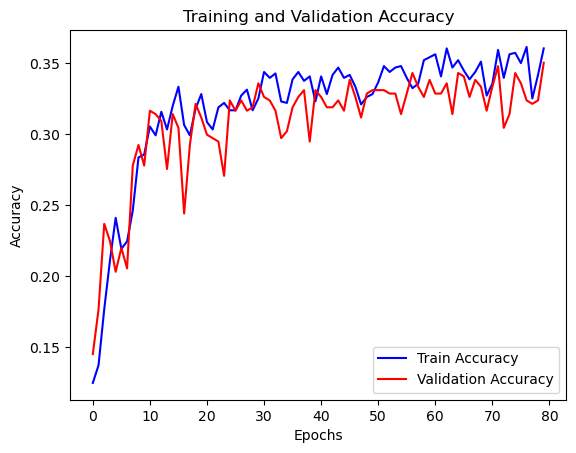

In [9]:
################## Task 1.BONUS ##################

x, y = make_dataset(images, labels, label_to_idx, (224,224)) # Recapturing the images and labels
new_input_matrix = np.zeros([x.shape[0], 7]) # Creating an empty matrix for our features to be added

for ii in range(0, x.shape[0]): # Adding features
    image = x[ii, :, :, :]
    red = np.mean(image[:,:, 0]) # red channel color mean, and below similarly blue and green
    blue = np.mean(image[:,:, 1])
    green = np.mean(image[:,:, 2])

    mean_of_whole = np.mean(image) # mean of whole channels

    red_var = np.var(image[:,:, 0]) # extracting next feature, variances
    blue_var = np.var(image[:,:, 1])
    green_var = np.var(image[:,:, 2])

    new_input_matrix[ii, :] = np.array([red, blue, green, mean_of_whole, red_var, blue_var, green_var]) # final new Input matrix


# Splitting our data into X/Y_train, and X/Y_test
X_train7, X_test7, y_train7, y_test7 = train_test_split(new_input_matrix, y, train_size=0.85, random_state=100)



# Again further splitting Training data into 30% X/Y Validation and 70% X/Y Training
X_train7, X_val7, y_train7, y_val7 = train_test_split(X_train7, y_train7, test_size=0.3, random_state=100)



# Normalizing data
X_train7 = X_train7/255.0
X_test7 = X_test7/255.0
X_val7 = X_val7/255.0


# Creating the supervised model using Sequential()
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train7.shape[1],))) # Adding the input layer, 64 units and relu activation function
model.add(Dense(units=32, activation='relu')) # Adding hidden layer
model.add(Dense(units=7, activation='softmax')) # Adding the output layer, units 7 assuming 7 classes (Lions,Puma...)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the model

# Training the model, saving it under history for later plotting
history = model.fit(X_train7, y_train7, epochs=80, batch_size=32, validation_data=(X_val7, y_val7),verbose=False)

# saving the model
save_keras_model(model,'model_2_Bonus.h5')


# Evaluating the model on the test set using the test Loss and Accuracy measures
test_loss, test_accuracy = model.evaluate(X_test7, y_test7)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


# Referencing the history for accuracy and val_accuracy set
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


# Plotting the accuracy values 
epochs = range(0, len(train_accuracy)) 
plt.plot(epochs, train_accuracy, 'b', label='Train Accuracy') # 'b' for blue distinguishing the Train accuracy
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy') # 'r' for red distinguishing the Validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
################## Task 2 ##################
# Splitting our data into X/Y_train, and X/Y_test
x, y = make_dataset(images, labels, label_to_idx, (224,224)) # getting images and labels again - unprocessed 
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.85, random_state=100)




# splitting Training data into 30% X/Y Validation and 70% X/Y Training
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100) 

X_train, X_test, X_val = X_train/255.0, X_test/255.0, X_val/255.0 # Normalizing data 

n_classes = 7 # Giving Classes & categorical values to y




# Instantiate the CNN model and add one Convo layer
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2))) # Add the first pooling layer

model.add(Conv2D(64, (3, 3), activation='relu')) # Add the second convo layer, and second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu')) # Add the third convo layer, and third pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # Flatten the feature maps

model.add(Dense(256, activation='relu')) # Add the first dense layer
model.add(Dense(128, activation='relu')) # Add the second dense layer
model.add(Dense(n_classes, activation='softmax')) # Add the output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model


# Early Stopping 
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)



# Training the model with early stopping as we fit the data
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)

# saving the model
save_keras_model(model,'CNN_model_T2.h5')

# Evaluating the model on the test set using the test Loss and Accuracy measures
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print('-'*200)


# Referencing the history for accuracy and val_accuracy set
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']




# creating the function for our model
def create_model(input_dim, n_classes):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model



# reshaping x into 1D
x = x / 255.0


# wrapping the Keras model in an estimator compatible with scikit_learn with the actual number of epochs trained 
model = KerasClassifier(build_fn=lambda: create_model(input_dim=x.shape[1], n_classes=7),
                              epochs=15, batch_size=32,verbose=False)

# using the Keras model with the cross_val_score tool in scikit_learn  
kfold = KFold(n_splits=5, shuffle=True, random_state=80)
scores = cross_val_score(model, x, y, cv=kfold)


# Setting confidence level and # of scores 
confidence_i = 0.95
num = len(scores)

# standard deviation of the scores (accuracies)
std_err = np.std(scores) / np.sqrt(num)

# margin error
m_error_95p = std_err * t.ppf((1 + confidence_i) / 2, num - 1)

# print settings
print('-'*200)
print("E-accuracy for this model: {:.5f} +- {:.5f}".format(np.mean(scores), m_error_95p))
print('-'*200)



def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)

    best_epoch = np.argmin(history.history['val_loss'])

    # Plot training & validation loss values
    plt.axvline(best_epoch, label='best_epoch', c='purple', ls='--', alpha=0.5)
    plt.plot(history.history['loss'], label='train_loss', c='purple')
    plt.plot(history.history['val_loss'], label='val_loss', c='turquoise')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss')
    plt.legend()

    plt.subplot(122)
    # Plot training & validation accuracy values
    plt.axvline(best_epoch, label='best_epoch', c='purple', ls='--', alpha=0.5)
    plt.plot(history.history['accuracy'], label='train_accuracy', c='purple')
    plt.plot(history.history['val_accuracy'], label='val_accuracy', c='turquoise')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)




################## 2.6 ##################
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import library for augmentation

train_gen = ImageDataGenerator(
    channel_shift_range=0.30,
    rotation_range=30,
    zoom_range=0.25,
    shear_range=20,
    horizontal_flip=True,  # Add horizontal flipping
    fill_mode='nearest'  # Fill in missing pixels using nearest neighbor
)


val_gen = ImageDataGenerator()


def plot_gen_sample(gen, n_cols=5, n_rows=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    batch = next(gen)[0]
    for ax, im in zip(axs.reshape(-1), batch):
        ax.axis('off')
        ax.imshow(im)

# Instantiate the CNN model and add one Convo layer
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2))) # Add the first pooling layer

model.add(Conv2D(64, (3, 3), activation='relu')) # Add the second convo layer, and second pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu')) # Add the third convo layer, and third pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # Flatten the feature maps

model.add(Dense(256, activation='relu')) # Add the first dense layer
model.add(Dense(128, activation='relu')) # Add the second dense layer
model.add(Dense(n_classes, activation='softmax')) # Add the output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Compile the model



nr, nc = 5,1 # to make it easier to see 

train_loader = train_gen.flow(X_train, y_train, batch_size=nr*nc)
plot_gen_sample(train_loader, nr, nc)


train_loader = train_gen.flow(X_train, y_train, batch_size=16)
val_loader = val_gen.flow(X_val, y_val, batch_size=X_val.shape[0])

history = model.fit(train_loader,
                         steps_per_epoch=X_train.shape[0]//16,
                         epochs=20, 
                         validation_data=val_loader,
                         validation_steps=1,
                         callbacks=[early_stopping])

scores = model.evaluate(X_test, y_test)

print('-'*200)
print('Test loss: {} - Accuracy: {}'.format(*scores))
print('-'*200)


In [ ]:
################## Task 2.BONUS ##################

# Splitting our data into X/Y_train, and X/Y_test
x, y = make_dataset(images, labels, label_to_idx, (224,224)) # getting images and labels again - unprocessed 
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=100)
classes = 7
x = x/255 # normalizing the data again

# Setting the seed at 80
np.random.seed(80)
keras.utils.set_random_seed(80)


# importing all the needed packages
from keras.models import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from scipy import stats
import numpy as np


def create_model(kernel_initializer='he_normal', padding='same'):
    model = Sequential()     # Initialize a Sequential model
    
    # Add the first convolutional layer
    model.add(Conv2D(16, (3, 3), activation='relu', padding=padding, kernel_initializer=kernel_initializer, input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))     # Add a max pooling layer

    # Add the second convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', padding=padding, kernel_initializer=kernel_initializer))
    model.add(MaxPooling2D((2, 2)))     # Add another max pooling layer

    # Add the third convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu', padding=padding, kernel_initializer=kernel_initializer))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())     # Flatten the output from the previous layer
    
    # Add a fully connected layer with 128 units and ReLU activation
    model.add(Dense(128, activation='relu', kernel_initializer=kernel_initializer))
    
    # Add another fully connected layer with 64 units and ReLU activation
    model.add(Dense(64, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #Compiling the model given categorial and adam
    
    return model

# creating a classifier model
model = KerasClassifier(build_fn=create_model, epochs=20,verbose=True)

# Gives the grid search parameters kernel_initializer and padding
param_grid = {'batch_size': [32,128],
            'padding': ['same', 'valid']}

# Other parameters such as drop_out_rate, learning_rate could be added but again very intensive computationally 

# creating the Grid Search , cross-validation "cv" being 3
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=False)
grid_result = grid.fit(X_train, y_train) # fitting the GridSearchCV

# getting the best model: best_estimator_.model
grid_model = grid.best_estimator_.model

# Saving our model 
save_keras_model(grid_model,'Model_4_T2_Bonus.h5')
scores_best = grid_model.evaluate(X_test, y_test,verbose=False) # evaluating the best_estimator_.model

# Store the information in variables
best_parameters = grid.best_params_
best_parameters_str = "Best parameters found: {}".format(best_parameters)
test_loss_str = "Test loss: {:.4}".format(scores_best[0])
test_accuracy_str = "Test accuracy: {:.4}".format(scores_best[1])

# Display the information
print(best_parameters_str)
print(test_loss_str + " - " + test_accuracy_str)



# loading back the T2_cnn - for comparison
Old_cnn = load_model('CNN_model_T2.h5') 

# evaluating the T2 cnn model
scores = Old_cnn.evaluate(X_test, y_test,verbose=False)

# Calculate the change in accuracy after grid search
change = round((scores_best[1] - scores[1]) * 100, 4)

# Display the information
print("-" * 200)
print(f"Final evaluation: change in accuracy after grid {change}%")
print("-" * 200)



################## KFOLD ##################
# Classification accuracu on uneen data using K-fold
# Create a KerasClassifier object, and wrapping with  best parameters,
# function 'padding' parameter from best_parameters.
final_gmodel = KerasClassifier(
    build_fn=lambda: create_model(padding=best_parameters['padding']),
    epochs=15, batch_size=best_parameters["batch_size"]
,verbose=False)


# Creating a KFold object for cross-validation.
kfold = KFold(n_splits=6, shuffle=True, random_state=80)


# Performing cv on the "final_gmodel" using the KFold object and Evaluate the model
results = cross_val_score(final_gmodel, x, y, cv=kfold)


# Set CI at 0.95
CI = 0.95

# Calculating the CI using the t-distribution based on the mean and standard error of the results
lower, upper = stats.t.interval(CI, len(results)-1, loc=np.mean(results), scale=stats.sem(results))


# Display the estimated classification accuracy along with the confidence interval.
# The mean value is formatted with 4 decimal places, and the interval is calculated.
print(f"{np.mean((lower, upper)):.4} +/- {(upper-lower)/2:.4}")

# Display the separator line.
separator = "-" * 200
print(separator)

